In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_validate

# permutation importance
from sklearn.inspection import permutation_importance

import category_encoders as ce


# read data
in_kaggle = False


def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/tabular-playground-series-feb-2021/train.csv'
        test_path = '../input/tabular-playground-series-feb-2021/test.csv'
        sample_submission_path = '../input/tabular-playground-series-jan-2021/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/test.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred) ** 0.5

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# fix skewness via abs sqrt transform
def sqrt_abs_transform(df: pd.DataFrame) -> pd.DataFrame:

    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = df[c].abs() ** 0.5
    
    return df

# fix skewness via log transform
def log_transform_numeric_cols(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = np.log(df[c].values+1)
    return df

# reverse log transform
def exp_transform_numeric_cols(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = np.exp(df[c].values)-1
    return df

In [3]:
# Additional feature engineering routines

# Function to extract common stats features
def add_stat_features(
    df: pd.DataFrame, 
    features_c: List[str]) -> pd.DataFrame:
    
    df['c_sum'] = df[features_c].sum(axis=1)
    df['c_mean'] = df[features_c].mean(axis=1)
    df['c_std'] = df[features_c].std(axis=1)
    df['c_kurt'] = df[features_c].kurtosis(axis=1)
    df['c_skew'] = df[features_c].skew(axis=1)

    return df

# function to add squared c-features
def add_squared(
    df: pd.DataFrame,  
    features_c: List[str]) -> pd.DataFrame:
    

    for feature in features_c:
        df[f'{feature}_squared'] = df[feature] ** 2
    return df

# function to add simple genetic features
def add_genetic_features(
    df: pd.DataFrame, 
    features_c: List[str],
    add_plus_features=True,
    add_minus_features=False,
    add_product_features=False,
    add_divided_features=False,
    add_plus_by_minus_features=False,
    add_plus_div_by_minus_features=False
) -> pd.DataFrame:
    
    small_val = 0.00001

    for col1 in features_c:
        for col2 in features_c:
            if col1 != col2:
                if add_plus_features:
                    df[f'{col1}_plus_{col2}'] = df[col1] + df[col2]
                if add_minus_features:
                    df[f'{col1}_minus_{col2}'] = df[col1] - df[col2]
                if add_product_features:
                    df[f'{col1}_prod_{col2}'] = df[col1] * df[col2]
                if add_divided_features:
                    df[f'{col1}_div_{col2}'] = df[col1] / ( df[col2] + small_val)
                if add_plus_by_minus_features:
                    df[f'{col1}_qq_{col2}'] = (df[col1] + df[col2]) * (df[col1] - df[col2])
                if add_plus_div_by_minus_features:
                    df[f'{col1}_div2_{col2}'] = (df[col1] - df[col2]) / (df[col1] + df[col2] + small_val)

    return df

# Here's how you use permutation importance
def get_permutation_importance(training_set, target, model) -> pd.DataFrame:
    model.fit(training_set, target)

    result = permutation_importance(model, training_set, target, n_repeats=1,
                                    random_state=0)

    # permutational importance results
    colnames = training_set.columns
    result_df = pd.DataFrame(colnames, columns=['feature'])
    result_df['permutation_importance'] = result.get('importances')

    return result_df

In [4]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

Started at  2021-02-10 22:18:43.063197


In [5]:
%%time
# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

df_train = pd.read_csv(train_set_path)
df_test = pd.read_csv(test_set_path)

subm = pd.read_csv(sample_subm_path)

Wall time: 1.62 s


In [6]:
df_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [7]:
# list of basic raw numeric features
num_feature_list = [col for col in df_train.columns if col.startswith('cont')]

# list of basic raw numeric features
cat_feature_list = [col for col in df_train.columns if col.startswith('cat')]


# target labels list
target = 'target'

# drop sig_id from train and test sets
df_train = df_train.drop(['id'], axis=1, errors='ignore')
df_test = df_test.drop(['id'], axis=1, errors='ignore')


In [8]:
# do additional feature engineering

encoder = ce.OrdinalEncoder(cols=cat_feature_list, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)
# df_test = encoder.transform(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [9]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb # LightGBM Model


#Additional scklearn functions
from sklearn import metrics   
from sklearn.model_selection import cross_val_score, KFold, cross_validate


# Setting stratified kfold upon the continuous target for future use
kfolds = 5
# Setting kfold for future use
kf = KFold(kfolds, random_state=42, shuffle=True)


# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

def print_lightgbm_feature_importance(X, y, estimator):
    #Print Feature Importance:
    estimator.fit(X, y)
    predictors = X.columns

    feat_imp = pd.Series(estimator.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.nlargest(30).plot(kind='barh', title='Feature Importances', figsize=(8,10))
    plt.ylabel('Feature Importance Score')
    df = feat_imp.to_frame().reset_index()
    df = df.rename(columns={'index': 'predictor', 0: "fi_score"})
    return df


def model_check(X, y, estimator, model_name, model_description, kfs, is_y_log_transformed=False):
    model_table = pd.DataFrame()
    
    train_rmse = []
    valid_rmse = []
    hideout_rmse = []

    fitting_start_time = dt.datetime.now()
    for i, (train_index, test_index) in enumerate(kfs.split(X)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index, :].copy(), X.iloc[test_index, :].copy()
        
        rmse = 0.0
        
        fit_model = model.fit(X_train, y_train)
        
        pred = model.predict(X_train)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_train = np.exp(y_train) - 1
            pred = np.exp(pred) - 1
        rmse = RMSLE(y_train, pred)
        print('RMSLE Regressor, training set, fold ', i, ': ', rmse)
        train_rmse.append(rmse)
        
        pred = model.predict(X_valid)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_valid = np.exp(y_valid) - 1
            pred = np.exp(pred) - 1
        rmse = RMSLE(y_valid, pred)
        print('RMSLE Regressor, validation set, fold ', i, ': ', rmse)
        valid_rmse.append(rmse)
        
        pred_hideout = model.predict(X_hideout)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_hideout_unscaled = np.exp(y_hideout) - 1
            pred_hideout = np.exp(pred_hideout) - 1
            rmse = RMSLE(y_hideout_unscaled, pred_hideout)
        else:
            rmse = RMSLE(y_hideout, pred_hideout)
        print('RMSLE Regressor, hideout set, fold ', i, ': ', rmse)
        hideout_rmse.append(rmse)
    
    fitting_end_time = dt.datetime.now()
    fit_time = fitting_end_time - fitting_start_time
    
    train_rmse = np.array(train_rmse)
    valid_rmse = np.array(valid_rmse)
    hideout_rmse = np.array(hideout_rmse)
        
    train_rmse = round(np.mean(train_rmse, axis=0), 4)
    val_rmse = round(np.mean(valid_rmse, axis=0), 4)
    test_rmse = round(np.mean(hideout_rmse, axis=0), 4)
    test_std = round(np.std(hideout_rmse, axis=0), 4)

    attributes = {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'valid_rmse': val_rmse,
        'test_rmse': test_rmse,
        'test_rmse_std': test_std,
        'fit_time': fit_time,
        'description': model_description,
    }
    
    model_table = pd.DataFrame(data=[attributes])
    return model_table

In [10]:
# initial not tuned model
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=50, 
    max_depth=-1, 
    random_state=314, 
    silent=True,  
    n_jobs=4, 
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    learning_rate=0.1)

# fit the baseline model with the training data
result_df = model_check(X_train, y_train, model, "Initial model: LE", "Initial baseline - LE", kf)
display(result_df.head())

RMSLE Regressor, training set, fold  0 :  0.8254395803901972
RMSLE Regressor, validation set, fold  0 :  0.8471177133245992
RMSLE Regressor, hideout set, fold  0 :  0.8477047670490575
RMSLE Regressor, training set, fold  1 :  0.8254577509049414
RMSLE Regressor, validation set, fold  1 :  0.8458715968223666
RMSLE Regressor, hideout set, fold  1 :  0.8476847901300144
RMSLE Regressor, training set, fold  2 :  0.8257213764305643
RMSLE Regressor, validation set, fold  2 :  0.8444260639330308
RMSLE Regressor, hideout set, fold  2 :  0.8470300963241496
RMSLE Regressor, training set, fold  3 :  0.8249268378143735
RMSLE Regressor, validation set, fold  3 :  0.8473332449188681
RMSLE Regressor, hideout set, fold  3 :  0.8474035887594409
RMSLE Regressor, training set, fold  4 :  0.8252864550449495
RMSLE Regressor, validation set, fold  4 :  0.846770694413391
RMSLE Regressor, hideout set, fold  4 :  0.8473666923258961


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial model: LE,0.8254,0.8463,0.8474,0.0002,0 days 00:00:09.561966,Initial baseline - LE


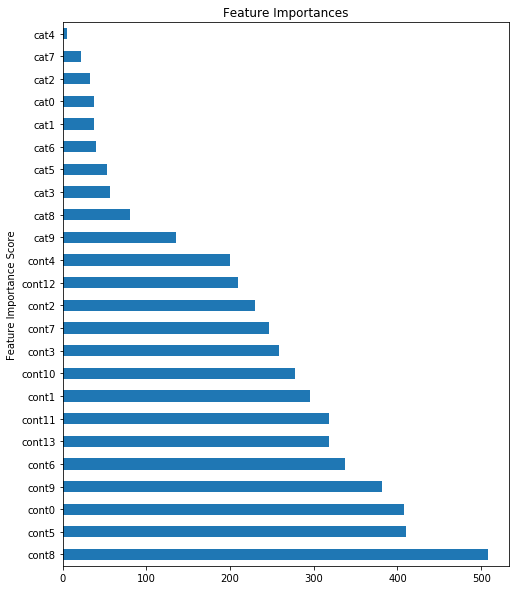

In [11]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [12]:
# OHE approach

# do additional feature engineering

encoder = ce.OneHotEncoder(cols=cat_feature_list, use_cat_names=True, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)

# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [13]:
# fit the baseline model with the training data
result2_df = model_check(X_train, y_train, model, "Initial model: OHE", "Initial baseline - OHE", kf)
display(result2_df.head())

RMSLE Regressor, training set, fold  0 :  0.8251274113765356
RMSLE Regressor, validation set, fold  0 :  0.8472485494826664
RMSLE Regressor, hideout set, fold  0 :  0.8476391112059873
RMSLE Regressor, training set, fold  1 :  0.825252952410935
RMSLE Regressor, validation set, fold  1 :  0.8457247417775715
RMSLE Regressor, hideout set, fold  1 :  0.8476516846486996
RMSLE Regressor, training set, fold  2 :  0.8254631071819676
RMSLE Regressor, validation set, fold  2 :  0.8448369556979022
RMSLE Regressor, hideout set, fold  2 :  0.8471795323784472
RMSLE Regressor, training set, fold  3 :  0.8250541893362834
RMSLE Regressor, validation set, fold  3 :  0.8480480237037447
RMSLE Regressor, hideout set, fold  3 :  0.8476785731745672
RMSLE Regressor, training set, fold  4 :  0.825190157295963
RMSLE Regressor, validation set, fold  4 :  0.8464687834623479
RMSLE Regressor, hideout set, fold  4 :  0.8475358941737566


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial model: OHE,0.8252,0.8465,0.8475,0.0002,0 days 00:00:13.088003,Initial baseline - OHE


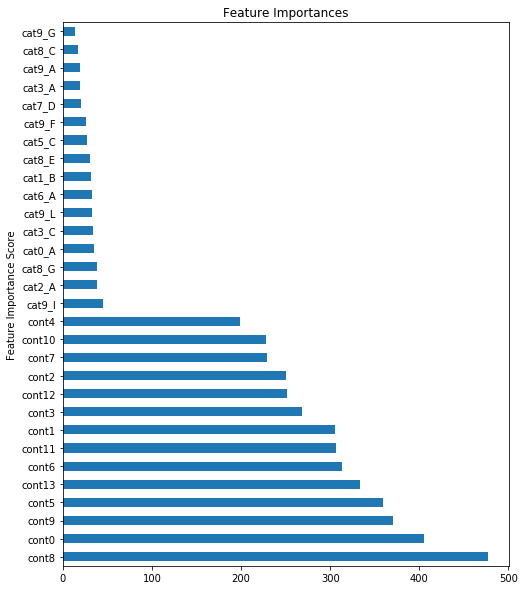

In [14]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [15]:
# OHE approach + skeweness correcting via log transform

# do additional feature engineering

encoder = ce.OneHotEncoder(cols=cat_feature_list, use_cat_names=True, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)

# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

X_train = log_transform_numeric_cols(X_train)
X_hideout = log_transform_numeric_cols(X_hideout)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [16]:
# fit the baseline model with the training data
result3_df = model_check(X_train, y_train, model, 
                         "Initial model: OHE+skewness correction", 
                         "Initial baseline - OHE+log transform", kf)
display(result3_df.head())

RMSLE Regressor, training set, fold  0 :  0.8251274113765356
RMSLE Regressor, validation set, fold  0 :  0.8472485494826664
RMSLE Regressor, hideout set, fold  0 :  0.8476391112059873
RMSLE Regressor, training set, fold  1 :  0.825252952410935
RMSLE Regressor, validation set, fold  1 :  0.8457247417775715
RMSLE Regressor, hideout set, fold  1 :  0.8476516846486996
RMSLE Regressor, training set, fold  2 :  0.8254631071819676
RMSLE Regressor, validation set, fold  2 :  0.8448369556979022
RMSLE Regressor, hideout set, fold  2 :  0.8471795323784472
RMSLE Regressor, training set, fold  3 :  0.8250541893362834
RMSLE Regressor, validation set, fold  3 :  0.8480480237037447
RMSLE Regressor, hideout set, fold  3 :  0.8476785731745672
RMSLE Regressor, training set, fold  4 :  0.825190157295963
RMSLE Regressor, validation set, fold  4 :  0.8464687834623479
RMSLE Regressor, hideout set, fold  4 :  0.847536048972705


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial model: OHE+skewness correction,0.8252,0.8465,0.8475,0.0002,0 days 00:00:12.641983,Initial baseline - OHE+log transform


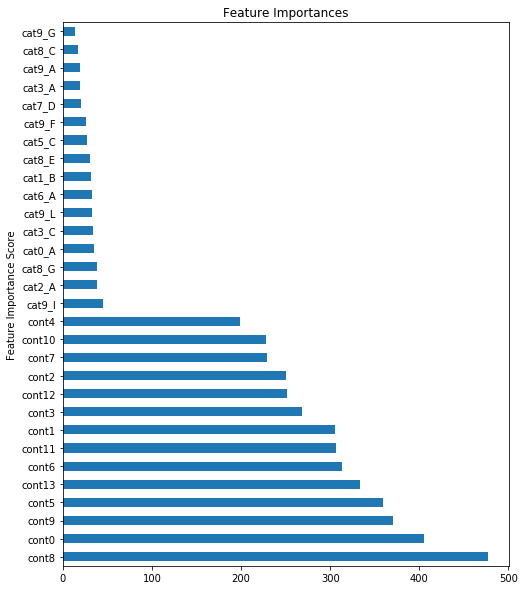

In [17]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [18]:
# do additional feature engineering: LE + skewness via log transform

encoder = ce.OrdinalEncoder(cols=cat_feature_list, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)
# df_test = encoder.transform(df_test)

# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

X_train = log_transform_numeric_cols(X_train)
X_hideout = log_transform_numeric_cols(X_hideout)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [19]:
# fit the baseline model with the training data
result4_df = model_check(X_train, y_train, model, 
                         "Initial model: LE+skewness log transform", 
                         "Initial baseline - LE+log transform", kf)
display(result4_df.head())

RMSLE Regressor, training set, fold  0 :  0.8254395803901972
RMSLE Regressor, validation set, fold  0 :  0.8471177133245992
RMSLE Regressor, hideout set, fold  0 :  0.8477047670490575
RMSLE Regressor, training set, fold  1 :  0.8254577509049414
RMSLE Regressor, validation set, fold  1 :  0.8458715968223666
RMSLE Regressor, hideout set, fold  1 :  0.8476847901300144
RMSLE Regressor, training set, fold  2 :  0.8257213764305643
RMSLE Regressor, validation set, fold  2 :  0.8444260639330308
RMSLE Regressor, hideout set, fold  2 :  0.8470300963241496
RMSLE Regressor, training set, fold  3 :  0.8249268378143735
RMSLE Regressor, validation set, fold  3 :  0.8473332449188681
RMSLE Regressor, hideout set, fold  3 :  0.8474035887594409
RMSLE Regressor, training set, fold  4 :  0.8252864550449495
RMSLE Regressor, validation set, fold  4 :  0.846770694413391
RMSLE Regressor, hideout set, fold  4 :  0.8473666923258961


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial model: LE+skewness log transform,0.8254,0.8463,0.8474,0.0002,0 days 00:00:09.437998,Initial baseline - LE+log transform


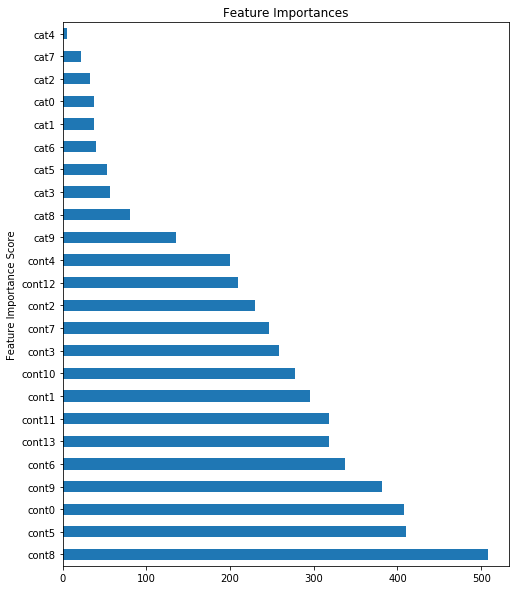

In [20]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [21]:
# do additional feature engineering: LE + skewness via abs sqrt

encoder = ce.OrdinalEncoder(cols=cat_feature_list, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)
# df_test = encoder.transform(df_test)

# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

X_train = sqrt_abs_transform(X_train)
X_hideout = sqrt_abs_transform(X_hideout)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [22]:
# fit the baseline model with the training data
result5_df = model_check(X_train, y_train, model, 
                         "Initial model: LE+skewness abs sqrt", 
                         "Initial baseline - LE+abs sqrt", kf)
display(result5_df.head())

RMSLE Regressor, training set, fold  0 :  0.8252894924866531
RMSLE Regressor, validation set, fold  0 :  0.8473014066071969
RMSLE Regressor, hideout set, fold  0 :  0.8474950077765678
RMSLE Regressor, training set, fold  1 :  0.8254168034409934
RMSLE Regressor, validation set, fold  1 :  0.8457167569073782
RMSLE Regressor, hideout set, fold  1 :  0.8472772108508955
RMSLE Regressor, training set, fold  2 :  0.8256739933512092
RMSLE Regressor, validation set, fold  2 :  0.8440874188351006
RMSLE Regressor, hideout set, fold  2 :  0.8473268588645341
RMSLE Regressor, training set, fold  3 :  0.825052714363372
RMSLE Regressor, validation set, fold  3 :  0.8480281283369844
RMSLE Regressor, hideout set, fold  3 :  0.8474648201595701
RMSLE Regressor, training set, fold  4 :  0.8253526300322083
RMSLE Regressor, validation set, fold  4 :  0.8467762680530335
RMSLE Regressor, hideout set, fold  4 :  0.8475725823904287


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial model: LE+skewness abs sqrt,0.8254,0.8464,0.8474,0.0001,0 days 00:00:09.498998,Initial baseline - LE+abs sqrt


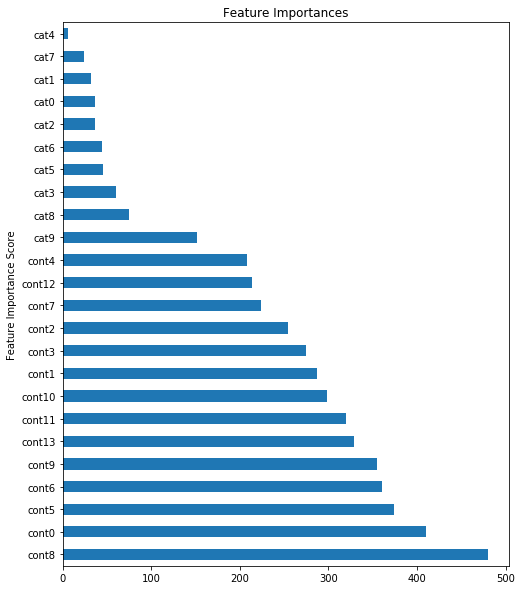

In [23]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [24]:
# OHE approach + skeweness correcting via sqrt abs

# do additional feature engineering

encoder = ce.OneHotEncoder(cols=cat_feature_list, use_cat_names=True, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)

# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

X_train = sqrt_abs_transform(X_train)
X_hideout = sqrt_abs_transform(X_hideout)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [25]:
# fit the baseline model with the training data
result6_df = model_check(X_train, y_train, model, 
                         "Initial model: OHE+skewness abs sqrt", 
                         "Initial baseline - OHE+abs sqrt", kf)
display(result6_df.head())

RMSLE Regressor, training set, fold  0 :  0.8250329573612943
RMSLE Regressor, validation set, fold  0 :  0.847329738066528
RMSLE Regressor, hideout set, fold  0 :  0.8476265623205183
RMSLE Regressor, training set, fold  1 :  0.8254379733263442
RMSLE Regressor, validation set, fold  1 :  0.8461787988265581
RMSLE Regressor, hideout set, fold  1 :  0.8477236689010476
RMSLE Regressor, training set, fold  2 :  0.825719660522597
RMSLE Regressor, validation set, fold  2 :  0.8447939383837513
RMSLE Regressor, hideout set, fold  2 :  0.8473376641658419
RMSLE Regressor, training set, fold  3 :  0.8247640959961358
RMSLE Regressor, validation set, fold  3 :  0.8477071694666468
RMSLE Regressor, hideout set, fold  3 :  0.8471036028621942
RMSLE Regressor, training set, fold  4 :  0.8249157381179414
RMSLE Regressor, validation set, fold  4 :  0.8465783536085042
RMSLE Regressor, hideout set, fold  4 :  0.8475897106193152


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial model: OHE+skewness abs sqrt,0.8252,0.8465,0.8475,0.0002,0 days 00:00:12.376001,Initial baseline - OHE+abs sqrt


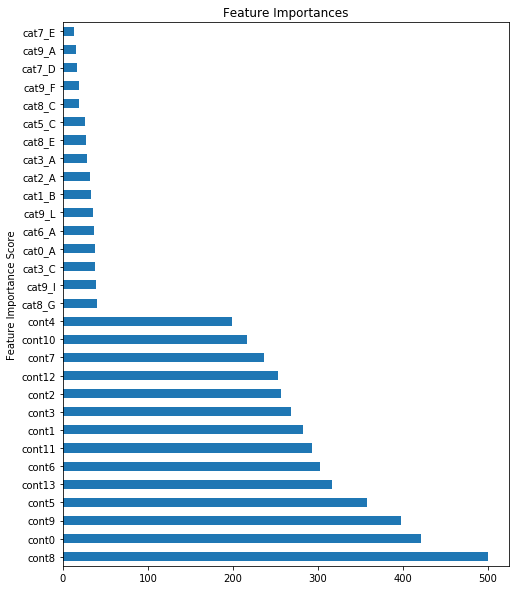

In [26]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [27]:
# do additional feature engineering: LE + skewness via abs sqrt, y log transformed

encoder = ce.OrdinalEncoder(cols=cat_feature_list, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)
# df_test = encoder.transform(df_test)

y = df_train_transformed['target']

# set a hideout fold 
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

# transform features via abs sqrt
X_train = sqrt_abs_transform(X_train)
X_hideout = sqrt_abs_transform(X_hideout)

# apply log transform to Y
y = np.log(y+1)
y_hideout = np.log(y_hideout+1)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [28]:
# fit the baseline model with the training data
result7_df = model_check(X_train, y_train, model, 
                         "Initial: LE+skewness abs sqrt + y log transformed", 
                         "Baseline - LE+abs sqrt + y log transformed", kf,
                        is_y_log_transformed=True)
display(result7_df.head())

RMSLE Regressor, training set, fold  0 :  2195.4891504359716
RMSLE Regressor, validation set, fold  0 :  2238.7993850840644
RMSLE Regressor, hideout set, fold  0 :  1840.438073037186
RMSLE Regressor, training set, fold  1 :  2199.549221255955
RMSLE Regressor, validation set, fold  1 :  2220.222920703907
RMSLE Regressor, hideout set, fold  1 :  1842.1573431057413
RMSLE Regressor, training set, fold  2 :  2202.0245544318714
RMSLE Regressor, validation set, fold  2 :  2204.2798537371195
RMSLE Regressor, hideout set, fold  2 :  1844.0337611459997
RMSLE Regressor, training set, fold  3 :  2195.5663957730676
RMSLE Regressor, validation set, fold  3 :  2227.7202242999692
RMSLE Regressor, hideout set, fold  3 :  1847.2064678484433
RMSLE Regressor, training set, fold  4 :  2190.8627196138723
RMSLE Regressor, validation set, fold  4 :  2255.3739678686743
RMSLE Regressor, hideout set, fold  4 :  1843.8268805893574


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial: LE+skewness abs sqrt + y log transformed,2196.6984,2229.2793,1843.5325,2.2496,0 days 00:00:09.352999,Baseline - LE+abs sqrt + y log transformed


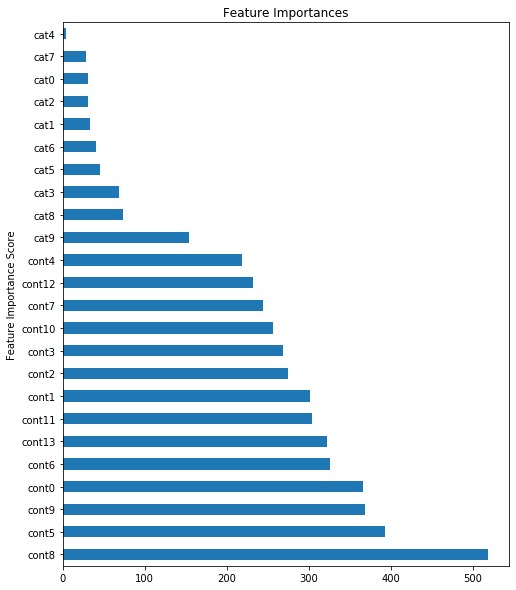

In [29]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [30]:
# do additional feature engineering: OHE + skewness via abs sqrt, y log transformed

encoder = ce.OneHotEncoder(cols=cat_feature_list, use_cat_names=True, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)
# df_test = encoder.transform(df_test)

y = df_train_transformed['target']

# set a hideout fold 
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

# transform features via abs sqrt
X_train = sqrt_abs_transform(X_train)
X_hideout = sqrt_abs_transform(X_hideout)

# apply log transform to Y
y = np.log(y+1)
y_hideout = np.log(y_hideout+1)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [31]:
# fit the baseline model with the training data
result8_df = model_check(X_train, y_train, model, 
                         "Initial: OHE+skewness abs sqrt + y log transformed", 
                         "Baseline - OHE+abs sqrt + y log transformed", kf,
                        is_y_log_transformed=True)
display(result8_df.head())

RMSLE Regressor, training set, fold  0 :  2195.0560913919935
RMSLE Regressor, validation set, fold  0 :  2237.7642801449756
RMSLE Regressor, hideout set, fold  0 :  1841.6094817613587
RMSLE Regressor, training set, fold  1 :  2199.2013454447006
RMSLE Regressor, validation set, fold  1 :  2220.2733017449195
RMSLE Regressor, hideout set, fold  1 :  1842.0393429708035
RMSLE Regressor, training set, fold  2 :  2201.054506786725
RMSLE Regressor, validation set, fold  2 :  2204.4068972271816
RMSLE Regressor, hideout set, fold  2 :  1846.5711037869562
RMSLE Regressor, training set, fold  3 :  2194.3906425830996
RMSLE Regressor, validation set, fold  3 :  2226.8308901504142
RMSLE Regressor, hideout set, fold  3 :  1848.1751936847515
RMSLE Regressor, training set, fold  4 :  2190.1333403890485
RMSLE Regressor, validation set, fold  4 :  2254.1969205046553
RMSLE Regressor, hideout set, fold  4 :  1844.0108946680825


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial: OHE+skewness abs sqrt + y log transfo...,2195.9672,2228.6945,1844.4812,2.5473,0 days 00:00:12.516979,Baseline - OHE+abs sqrt + y log transformed


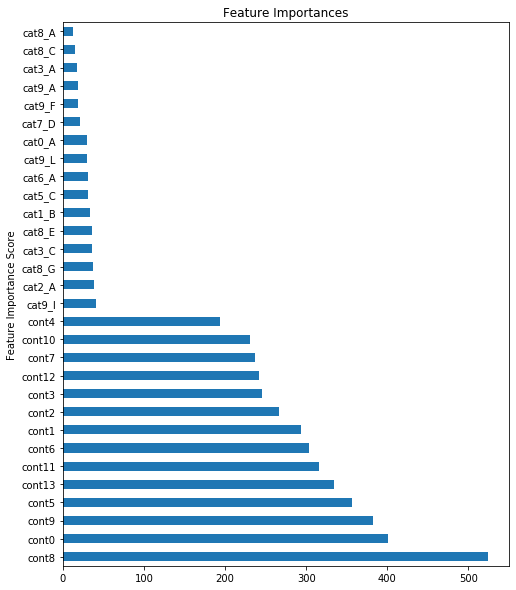

In [32]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [33]:
# do additional feature engineering: LE + skewness via abs sqrt + new features

encoder = ce.OrdinalEncoder(cols=cat_feature_list, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)
# df_test = encoder.transform(df_test)

# abs sqrt transform
y = df_train_transformed['target']
df_train_transformed = df_train_transformed.drop(['target'], axis=1, errors='ignore')
df_train_transformed = sqrt_abs_transform(df_train_transformed)

# add new features
df_train_transformed = add_stat_features(df_train_transformed, num_feature_list)
df_train_transformed = add_squared(df_train_transformed, num_feature_list)

df_train_transformed = add_genetic_features(
    df_train_transformed, 
    num_feature_list,
    add_plus_features=True,
    add_minus_features=True,
    add_product_features=True,
    add_divided_features=True,
    add_plus_by_minus_features=True,
    add_plus_div_by_minus_features=True
)


# set a hideout fold 
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train_golden = X_train.copy()
X_hideout_golden = X_hideout.copy()

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [34]:
# fit the baseline model with the training data
result9_df = model_check(X_train, y_train, model, 
                         "Initial: LE+skewness abs sqrt + new features", 
                         "Baseline - LE+abs sqrt + new features", kf)
display(result9_df.head())

RMSLE Regressor, training set, fold  0 :  0.8163279033998572
RMSLE Regressor, validation set, fold  0 :  0.8491616552546157
RMSLE Regressor, hideout set, fold  0 :  0.8498258702015694
RMSLE Regressor, training set, fold  1 :  0.8165073963690181
RMSLE Regressor, validation set, fold  1 :  0.8477402786864808
RMSLE Regressor, hideout set, fold  1 :  0.8496938437757283
RMSLE Regressor, training set, fold  2 :  0.8168010293432285
RMSLE Regressor, validation set, fold  2 :  0.8467009663843863
RMSLE Regressor, hideout set, fold  2 :  0.8496064829866778
RMSLE Regressor, training set, fold  3 :  0.81601535768821
RMSLE Regressor, validation set, fold  3 :  0.8495626938780718
RMSLE Regressor, hideout set, fold  3 :  0.8497346947526465
RMSLE Regressor, training set, fold  4 :  0.816236605357353
RMSLE Regressor, validation set, fold  4 :  0.8479498966970985
RMSLE Regressor, hideout set, fold  4 :  0.8493718515381206


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial: LE+skewness abs sqrt + new features,0.8164,0.8482,0.8496,0.0002,0 days 00:06:31.608093,Baseline - LE+abs sqrt + new features


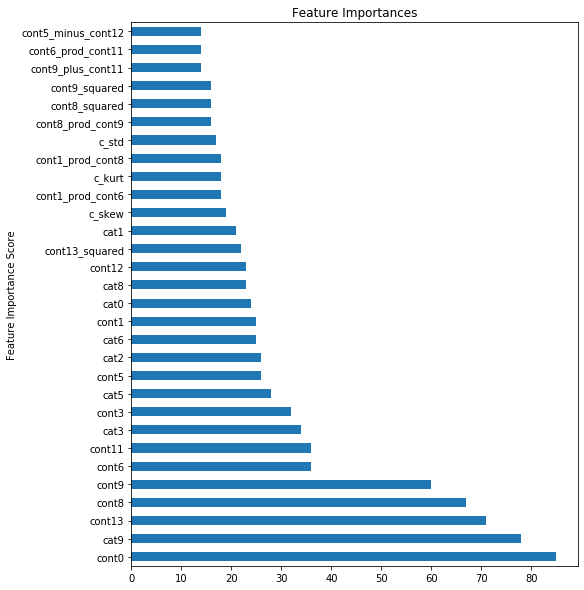

In [35]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [36]:
# interim results 

results_df = pd.concat([result_df, result2_df, result3_df, result4_df, result5_df, result6_df,
                       result7_df, result8_df, result9_df])

results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,0.825400,0.846300,0.847400,0.000200,0 days 00:00:09.561966,Initial baseline - LE
3,0.825400,0.846300,0.847400,0.000200,0 days 00:00:09.437998,Initial baseline - LE+log transform
4,0.825400,0.846400,0.847400,0.000100,0 days 00:00:09.498998,Initial baseline - LE+abs sqrt
1,0.825200,0.846500,0.847500,0.000200,0 days 00:00:13.088003,Initial baseline - OHE
2,0.825200,0.846500,0.847500,0.000200,0 days 00:00:12.641983,Initial baseline - OHE+log transform
5,0.825200,0.846500,0.847500,0.000200,0 days 00:00:12.376001,Initial baseline - OHE+abs sqrt
8,0.816400,0.848200,0.849600,0.000200,0 days 00:06:31.608093,Baseline - LE+abs sqrt + new features
6,2196.698400,2229.279300,1843.532500,2.249600,0 days 00:00:09.352999,Baseline - LE+abs sqrt + y log transformed
7,2195.967200,2228.694500,1844.481200,2.547300,0 days 00:00:12.516979,Baseline - OHE+abs sqrt + y log transformed


In [37]:
permutate_df = pd.read_csv("reports/lightgbm_le_permutate_feature_importance.csv")

In [38]:
permutate_df.reset_index().sort_values('permutation_importance', 
                   ascending=False)[
                        [ 
                            'feature', 'permutation_importance'
                        ]
                ][:90].style.background_gradient(cmap='Oranges')

,feature,permutation_importance
1,cat1,0.026840
9,cat9,0.015865
23,cont13,0.011473
3,cat3,0.009736
2,cat2,0.009164
19,cont9,0.008351
18,cont8,0.007846
13,cont3,0.006269
10,cont0,0.006136
21,cont11,0.006001


In [39]:
# interim results 
results_df = pd.concat([result_df, result2_df, result3_df, result4_df, result5_df, result6_df,
                       result7_df, result8_df, result9_df])

impactful_features_df = permutate_df[permutate_df['permutation_importance'] > 0.0]
impactful_features_df.sort_values(by='permutation_importance', ascending=False)
impactful_features_df.shape

(970, 2)

In [40]:
# do iterative model scoring on the top of permutative features
n_features = 10
for i in range(n_features, 101):
    top_features_df = impactful_features_df.head(i)
    top_features = top_features_df['feature'].tolist()
    
    # subset train and hideout sets by the features listed
    X_train = X_train_golden[top_features]
    X_hideout = X_hideout_golden[top_features]
    
    print("---------------------------------")
    print("Starting to check the model on", i, " top-importance features")
    
    # fit the baseline model with the training data
    model_name = "".join(['LE+skewness abs sqrt; top ', str(i), ' PIF'])
    model_description = "".join(['Baseline: LE+abs sqrt; top ', str(i), ' PI features'])
    res_df = model_check(X_train, y_train, model, 
                         model_name, 
                         model_description, 
                         kf)
    results_df = pd.concat([results_df, res_df])
    print("Finished to check the model on", i, " top-importance features (permutation importance)")


---------------------------------
Starting to check the model on 10  top-importance features
RMSLE Regressor, training set, fold  0 :  0.8639879572800739
RMSLE Regressor, validation set, fold  0 :  0.8699279858016583
RMSLE Regressor, hideout set, fold  0 :  0.8706351181412878
RMSLE Regressor, training set, fold  1 :  0.8643352739247504
RMSLE Regressor, validation set, fold  1 :  0.8687288171866411
RMSLE Regressor, hideout set, fold  1 :  0.8704885977594558
RMSLE Regressor, training set, fold  2 :  0.8647085114902289
RMSLE Regressor, validation set, fold  2 :  0.8672939293883206
RMSLE Regressor, hideout set, fold  2 :  0.8707258581919844
RMSLE Regressor, training set, fold  3 :  0.8640070140014705
RMSLE Regressor, validation set, fold  3 :  0.8697906222568063
RMSLE Regressor, hideout set, fold  3 :  0.8704739436134793
RMSLE Regressor, training set, fold  4 :  0.8646693891376821
RMSLE Regressor, validation set, fold  4 :  0.8673991153018304
RMSLE Regressor, hideout set, fold  4 :  0.8705

RMSLE Regressor, hideout set, fold  2 :  0.8581954024069046
RMSLE Regressor, training set, fold  3 :  0.8398439084606375
RMSLE Regressor, validation set, fold  3 :  0.8586265677709508
RMSLE Regressor, hideout set, fold  3 :  0.8585660312333759
RMSLE Regressor, training set, fold  4 :  0.8401298591553985
RMSLE Regressor, validation set, fold  4 :  0.8565488508036957
RMSLE Regressor, hideout set, fold  4 :  0.8584686549683036
Finished to check the model on 17  top-importance features (permutation importance)
---------------------------------
Starting to check the model on 18  top-importance features
RMSLE Regressor, training set, fold  0 :  0.838457167834469
RMSLE Regressor, validation set, fold  0 :  0.8583161297340534
RMSLE Regressor, hideout set, fold  0 :  0.857873633892337
RMSLE Regressor, training set, fold  1 :  0.8387415268127706
RMSLE Regressor, validation set, fold  1 :  0.8562668719812147
RMSLE Regressor, hideout set, fold  1 :  0.8582297513946541
RMSLE Regressor, training set

RMSLE Regressor, training set, fold  0 :  0.8252235497938631
RMSLE Regressor, validation set, fold  0 :  0.8475343855953787
RMSLE Regressor, hideout set, fold  0 :  0.847755732523608
RMSLE Regressor, training set, fold  1 :  0.8254716533899644
RMSLE Regressor, validation set, fold  1 :  0.8459690743278933
RMSLE Regressor, hideout set, fold  1 :  0.8480268443988114
RMSLE Regressor, training set, fold  2 :  0.8256807740709049
RMSLE Regressor, validation set, fold  2 :  0.8448636326995446
RMSLE Regressor, hideout set, fold  2 :  0.8475146954698384
RMSLE Regressor, training set, fold  3 :  0.8250119673986175
RMSLE Regressor, validation set, fold  3 :  0.8480115589610832
RMSLE Regressor, hideout set, fold  3 :  0.8475601809776478
RMSLE Regressor, training set, fold  4 :  0.8251699079277615
RMSLE Regressor, validation set, fold  4 :  0.846598626658563
RMSLE Regressor, hideout set, fold  4 :  0.8475755966274876
Finished to check the model on 25  top-importance features (permutation importance

RMSLE Regressor, training set, fold  3 :  0.8242797083536307
RMSLE Regressor, validation set, fold  3 :  0.8479492969127456
RMSLE Regressor, hideout set, fold  3 :  0.8479061938419483
RMSLE Regressor, training set, fold  4 :  0.8246336355026601
RMSLE Regressor, validation set, fold  4 :  0.8465372137169254
RMSLE Regressor, hideout set, fold  4 :  0.847707197487186
Finished to check the model on 32  top-importance features (permutation importance)
---------------------------------
Starting to check the model on 33  top-importance features
RMSLE Regressor, training set, fold  0 :  0.8245949186650816
RMSLE Regressor, validation set, fold  0 :  0.8479009710966721
RMSLE Regressor, hideout set, fold  0 :  0.8480238655188804
RMSLE Regressor, training set, fold  1 :  0.8250390761070241
RMSLE Regressor, validation set, fold  1 :  0.8459389269767358
RMSLE Regressor, hideout set, fold  1 :  0.8479387930384946
RMSLE Regressor, training set, fold  2 :  0.8252018169986515
RMSLE Regressor, validation

RMSLE Regressor, training set, fold  0 :  0.8243155542924193
RMSLE Regressor, validation set, fold  0 :  0.8476278838308462
RMSLE Regressor, hideout set, fold  0 :  0.8480129285980817
RMSLE Regressor, training set, fold  1 :  0.8246823506230224
RMSLE Regressor, validation set, fold  1 :  0.846127318234506
RMSLE Regressor, hideout set, fold  1 :  0.8480536021318947
RMSLE Regressor, training set, fold  2 :  0.8249067870552809
RMSLE Regressor, validation set, fold  2 :  0.8446585417911141
RMSLE Regressor, hideout set, fold  2 :  0.8478012443437761
RMSLE Regressor, training set, fold  3 :  0.8239104745570309
RMSLE Regressor, validation set, fold  3 :  0.8477699536515884
RMSLE Regressor, hideout set, fold  3 :  0.8480710503874552
RMSLE Regressor, training set, fold  4 :  0.824339213478147
RMSLE Regressor, validation set, fold  4 :  0.8464417782989058
RMSLE Regressor, hideout set, fold  4 :  0.8482501555501155
Finished to check the model on 40  top-importance features (permutation importance

RMSLE Regressor, training set, fold  3 :  0.8236436437443568
RMSLE Regressor, validation set, fold  3 :  0.8484525248979468
RMSLE Regressor, hideout set, fold  3 :  0.8484422201441112
RMSLE Regressor, training set, fold  4 :  0.8239541061995717
RMSLE Regressor, validation set, fold  4 :  0.8466719975155927
RMSLE Regressor, hideout set, fold  4 :  0.8482410196073721
Finished to check the model on 47  top-importance features (permutation importance)
---------------------------------
Starting to check the model on 48  top-importance features
RMSLE Regressor, training set, fold  0 :  0.8239566675807509
RMSLE Regressor, validation set, fold  0 :  0.8477918689508789
RMSLE Regressor, hideout set, fold  0 :  0.8485752310682569
RMSLE Regressor, training set, fold  1 :  0.8241034061387754
RMSLE Regressor, validation set, fold  1 :  0.8462894538699793
RMSLE Regressor, hideout set, fold  1 :  0.8483024801556727
RMSLE Regressor, training set, fold  2 :  0.8243094400005112
RMSLE Regressor, validatio

RMSLE Regressor, training set, fold  0 :  0.8234783694096396
RMSLE Regressor, validation set, fold  0 :  0.8478735897343118
RMSLE Regressor, hideout set, fold  0 :  0.848115404842387
RMSLE Regressor, training set, fold  1 :  0.8235554156111086
RMSLE Regressor, validation set, fold  1 :  0.8461924135365729
RMSLE Regressor, hideout set, fold  1 :  0.8481032064693074
RMSLE Regressor, training set, fold  2 :  0.8241955777471086
RMSLE Regressor, validation set, fold  2 :  0.8448725218471045
RMSLE Regressor, hideout set, fold  2 :  0.8478789311894163
RMSLE Regressor, training set, fold  3 :  0.8232691622710973
RMSLE Regressor, validation set, fold  3 :  0.8486251618957792
RMSLE Regressor, hideout set, fold  3 :  0.848213903171463
RMSLE Regressor, training set, fold  4 :  0.8234597467734667
RMSLE Regressor, validation set, fold  4 :  0.8470231669106658
RMSLE Regressor, hideout set, fold  4 :  0.8479835642396951
Finished to check the model on 55  top-importance features (permutation importance

RMSLE Regressor, training set, fold  3 :  0.8229434791663355
RMSLE Regressor, validation set, fold  3 :  0.8485766796364695
RMSLE Regressor, hideout set, fold  3 :  0.8479466454769652
RMSLE Regressor, training set, fold  4 :  0.8231210184316593
RMSLE Regressor, validation set, fold  4 :  0.8470435214510251
RMSLE Regressor, hideout set, fold  4 :  0.848070470032855
Finished to check the model on 62  top-importance features (permutation importance)
---------------------------------
Starting to check the model on 63  top-importance features
RMSLE Regressor, training set, fold  0 :  0.8231045713991212
RMSLE Regressor, validation set, fold  0 :  0.8479245480684403
RMSLE Regressor, hideout set, fold  0 :  0.8482075637492031
RMSLE Regressor, training set, fold  1 :  0.8235379269772047
RMSLE Regressor, validation set, fold  1 :  0.8468164934074823
RMSLE Regressor, hideout set, fold  1 :  0.8485233613672319
RMSLE Regressor, training set, fold  2 :  0.8240562614331339
RMSLE Regressor, validation

RMSLE Regressor, training set, fold  0 :  0.822988554041502
RMSLE Regressor, validation set, fold  0 :  0.8476087249965694
RMSLE Regressor, hideout set, fold  0 :  0.8484870885515627
RMSLE Regressor, training set, fold  1 :  0.8232066671154048
RMSLE Regressor, validation set, fold  1 :  0.8465020397391317
RMSLE Regressor, hideout set, fold  1 :  0.8482756453952834
RMSLE Regressor, training set, fold  2 :  0.8236238023911705
RMSLE Regressor, validation set, fold  2 :  0.8453184498689288
RMSLE Regressor, hideout set, fold  2 :  0.8481626764914555
RMSLE Regressor, training set, fold  3 :  0.8224772633786979
RMSLE Regressor, validation set, fold  3 :  0.8488062488790483
RMSLE Regressor, hideout set, fold  3 :  0.8483172825787075
RMSLE Regressor, training set, fold  4 :  0.8230395354818403
RMSLE Regressor, validation set, fold  4 :  0.8471507685928438
RMSLE Regressor, hideout set, fold  4 :  0.8484586358321013
Finished to check the model on 70  top-importance features (permutation importanc

RMSLE Regressor, training set, fold  3 :  0.8224489437659338
RMSLE Regressor, validation set, fold  3 :  0.8490704331139376
RMSLE Regressor, hideout set, fold  3 :  0.8482191183062692
RMSLE Regressor, training set, fold  4 :  0.8226425904096674
RMSLE Regressor, validation set, fold  4 :  0.8473645102375167
RMSLE Regressor, hideout set, fold  4 :  0.8482886141073437
Finished to check the model on 77  top-importance features (permutation importance)
---------------------------------
Starting to check the model on 78  top-importance features
RMSLE Regressor, training set, fold  0 :  0.8229679161069055
RMSLE Regressor, validation set, fold  0 :  0.8481131843775259
RMSLE Regressor, hideout set, fold  0 :  0.8484526187257622
RMSLE Regressor, training set, fold  1 :  0.8230738749654407
RMSLE Regressor, validation set, fold  1 :  0.847039962844415
RMSLE Regressor, hideout set, fold  1 :  0.8487134443926576
RMSLE Regressor, training set, fold  2 :  0.8234614671818152
RMSLE Regressor, validation

RMSLE Regressor, training set, fold  0 :  0.8224914659224891
RMSLE Regressor, validation set, fold  0 :  0.8479045604466365
RMSLE Regressor, hideout set, fold  0 :  0.8485414471214003
RMSLE Regressor, training set, fold  1 :  0.822783572495855
RMSLE Regressor, validation set, fold  1 :  0.8471854357695875
RMSLE Regressor, hideout set, fold  1 :  0.8482105840800932
RMSLE Regressor, training set, fold  2 :  0.8229308767902139
RMSLE Regressor, validation set, fold  2 :  0.8453925443765218
RMSLE Regressor, hideout set, fold  2 :  0.8480561887009634
RMSLE Regressor, training set, fold  3 :  0.8219887560246195
RMSLE Regressor, validation set, fold  3 :  0.8487731883287775
RMSLE Regressor, hideout set, fold  3 :  0.8484214354178847
RMSLE Regressor, training set, fold  4 :  0.8224211834691417
RMSLE Regressor, validation set, fold  4 :  0.8472977601774719
RMSLE Regressor, hideout set, fold  4 :  0.8484176425329847
Finished to check the model on 85  top-importance features (permutation importanc

RMSLE Regressor, training set, fold  3 :  0.8218610463956841
RMSLE Regressor, validation set, fold  3 :  0.84883699783088
RMSLE Regressor, hideout set, fold  3 :  0.8481885826322858
RMSLE Regressor, training set, fold  4 :  0.8221463239712268
RMSLE Regressor, validation set, fold  4 :  0.8473544146236104
RMSLE Regressor, hideout set, fold  4 :  0.8485145959223549
Finished to check the model on 92  top-importance features (permutation importance)
---------------------------------
Starting to check the model on 93  top-importance features
RMSLE Regressor, training set, fold  0 :  0.8222972420097213
RMSLE Regressor, validation set, fold  0 :  0.8479890924450192
RMSLE Regressor, hideout set, fold  0 :  0.8485342601829958
RMSLE Regressor, training set, fold  1 :  0.8222340796332479
RMSLE Regressor, validation set, fold  1 :  0.84676734529408
RMSLE Regressor, hideout set, fold  1 :  0.8487452831642339
RMSLE Regressor, training set, fold  2 :  0.8228959345992921
RMSLE Regressor, validation se

RMSLE Regressor, training set, fold  0 :  0.8217471359713556
RMSLE Regressor, validation set, fold  0 :  0.8485852855842153
RMSLE Regressor, hideout set, fold  0 :  0.8489125478874546
RMSLE Regressor, training set, fold  1 :  0.8220359394660143
RMSLE Regressor, validation set, fold  1 :  0.8469057789304865
RMSLE Regressor, hideout set, fold  1 :  0.8489819719484023
RMSLE Regressor, training set, fold  2 :  0.8226754446914792
RMSLE Regressor, validation set, fold  2 :  0.8454243201682823
RMSLE Regressor, hideout set, fold  2 :  0.8485052942311472
RMSLE Regressor, training set, fold  3 :  0.8215787665482837
RMSLE Regressor, validation set, fold  3 :  0.8487506782706593
RMSLE Regressor, hideout set, fold  3 :  0.8486776067288073
RMSLE Regressor, training set, fold  4 :  0.8218930580217276
RMSLE Regressor, validation set, fold  4 :  0.8471267976649266
RMSLE Regressor, hideout set, fold  4 :  0.8484997083303292
Finished to check the model on 100  top-importance features (permutation importa

In [41]:
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,0.825400,0.846300,0.847400,0.000200,0 days 00:00:09.561966,Initial baseline - LE
3,0.825400,0.846300,0.847400,0.000200,0 days 00:00:09.437998,Initial baseline - LE+log transform
4,0.825400,0.846400,0.847400,0.000100,0 days 00:00:09.498998,Initial baseline - LE+abs sqrt
23,0.825400,0.846400,0.847400,0.000100,0 days 00:00:09.749999,Baseline: LE+abs sqrt; top 24 PI features
1,0.825200,0.846500,0.847500,0.000200,0 days 00:00:13.088003,Initial baseline - OHE
2,0.825200,0.846500,0.847500,0.000200,0 days 00:00:12.641983,Initial baseline - OHE+log transform
5,0.825200,0.846500,0.847500,0.000200,0 days 00:00:12.376001,Initial baseline - OHE+abs sqrt
25,0.825200,0.846600,0.847600,0.000200,0 days 00:00:10.143994,Baseline: LE+abs sqrt; top 26 PI features
27,0.824900,0.846500,0.847700,0.000200,0 days 00:00:10.857008,Baseline: LE+abs sqrt; top 28 PI features
24,0.825300,0.846600,0.847700,0.000200,0 days 00:00:10.178003,Baseline: LE+abs sqrt; top 25 PI features


In [42]:
results_df.to_csv('reports/model_scoring_lightgbm.csv', index=False)

In [46]:
# top 24 important features
top_features_df = impactful_features_df.head(24)
top_features_df['feature'].values

array(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11',
       'cont12', 'cont13'], dtype=object)

In [43]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

We are done. That is all, folks!
Finished at  2021-02-10 22:56:03.788781
Elapsed time:  0:37:20.725584
